# Convert ASCII Grid File to Cloud Optimised GeoTIFF

Downloads a zipped ASCII grid elevation file and exports it as a COG.

The zip file contains:
1. The raster data (.asc file)
2. The data's projection (.prj file)
3. A metadata html file (which we'll ignore)

### Load packages

In [115]:
# import boto3
import io
import os
import pathlib
import rasterio.crs
# import rasterio.plot
import requests
import zipfile

from matplotlib import pyplot
from rasterio.io import MemoryFile
from rio_cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles


### Settings

In [116]:
# the URL of the elevation data to download
url = "https://portal.spatial.nsw.gov.au/download/dem/56/Sydney-DEM-AHD_56_5m.zip"

# the path to save the images to
output_path = "./data"

download_path = os.path.join(output_path, "downloaded")
converted_path = os.path.join(output_path, "converted")

# create required data directories (if required)
pathlib.Path(download_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(converted_path).mkdir(exist_ok=True)

### Download file

...and extract its contents into a list of in-memory files

In [117]:
%%time
# download zipfile
response = requests.get(url)         

CPU times: user 430 ms, sys: 245 ms, total: 675 ms
Wall time: 4.23 s


In [118]:
%%time
# extract each file from zipfile & add to list of (filename, file-like object) pairs
file_list = list()
with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    for zipinfo in thezip.infolist():
        with thezip.open(zipinfo) as thefile:
            file_list.append((zipinfo.filename, thefile.read()))   

CPU times: user 2.93 s, sys: 384 ms, total: 3.31 s
Wall time: 3.36 s


### Load raster file & get it's coordinate system

Also, save files to disk for testing (not required for conversion to COG)

File size: 790mb

In [119]:
%%time
image = None
crs = None
input_file_name = None
output_file_name = None

for file in file_list:
    file_name = file[0]
    file_obj = file[1]

    # get image as an in-memory file.
    if file_name.endswith(".asc"):
        image = MemoryFile(file_obj)
        input_file_name = file_name
        output_file_name = file_name.replace(".asc", ".tif")

    # get well known text coordinate system
    if file_name.endswith(".prj"):
        proj_string = file_obj.decode("utf-8")
        crs = rasterio.crs.CRS.from_wkt(proj_string)

    # save file to disk
    with open(os.path.join(download_path, file_name), "wb") as f:
        f.write(file_obj)

CPU times: user 1.31 ms, sys: 282 ms, total: 284 ms
Wall time: 1.48 s


### Convert to COG

Take the raster file & it's coordinate system and convert to a cloud optimised geotiff (COG)

This takes ~13 seconds on a 2017 Mac

COG file size: 240mb

In [120]:
%%time
# create COG profile and set the image compression type & coordinate system
dst_profile = cog_profiles.get("deflate")
dst_profile.update({"crs": str(crs)})

# convert the raster dataset
with MemoryFile() as output_image:
    cog_translate(dataset, output_image.name, dst_profile, in_memory=True, nodata=-9999)

    # save the COG to disk
    with open(os.path.join(converted_path, output_file_name), "wb") as f:
        f.write(output_image.read())

Reading input: <open DatasetReader name='./data/converted/Sydney-DEM-AHD_56_5m.tif' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /vsimem/46d491ec-52b3-464b-823b-197ce109ffc2/46d491ec-52b3-464b-823b-197ce109ffc2.tif


CPU times: user 8.69 s, sys: 1.02 s, total: 9.71 s
Wall time: 10.2 s


### Display the ASCII grid file

We'll compare the plot time to the COG file once we've created it.

This takes ~12 seconds on a 2017 Mac

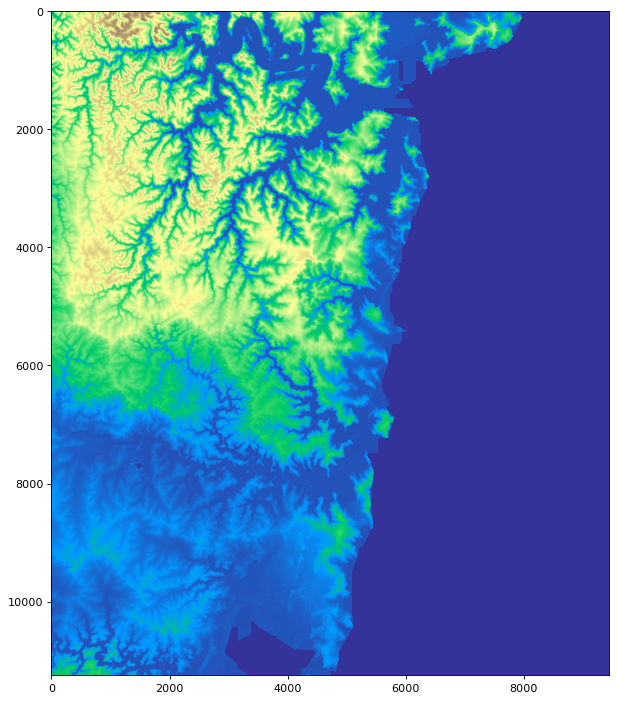

CPU times: user 12.3 s, sys: 1.28 s, total: 13.6 s
Wall time: 13.5 s


In [128]:
    %%time
    # open the file
    dataset = rasterio.open(os.path.join(download_path, input_file_name), "r")

    # get the data as a Numpy array
    np_data = dataset.read(1)

    fig = pyplot.figure(figsize=(9, 12), dpi=80)

    #     ax = pyplot.Axes(fig, [0., 0., 1., 1.])
    #     ax.set_axis_off()
    #     ax.set_title("ASCII Grid File - Sydney, NSW Elevation", fontsize = 16);

    pyplot.imshow(np_data, cmap="terrain", vmin=-20, vmax=400)
    pyplot.show()

### Display the COG file

Should be a lot faster

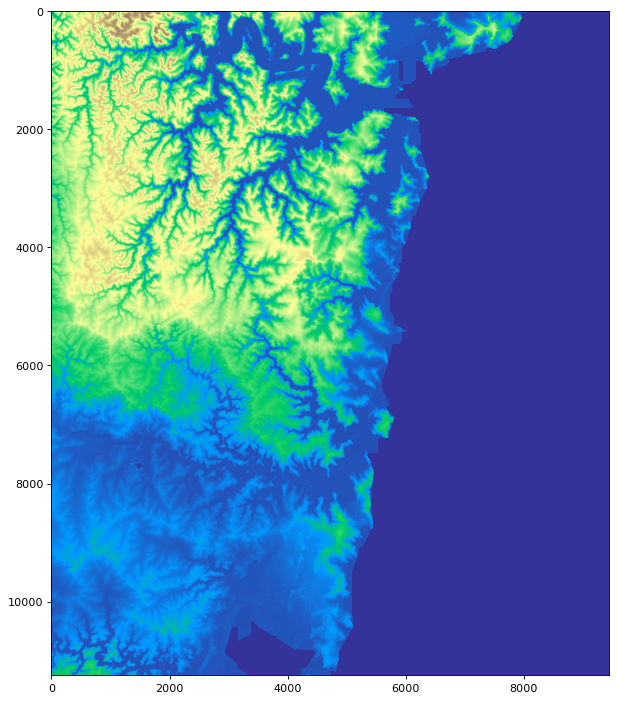

CPU times: user 5.09 s, sys: 1.06 s, total: 6.15 s
Wall time: 6.35 s


In [129]:
   %%time
    # open the file
    dataset = rasterio.open(os.path.join(converted_path, output_file_name), "r")

    # get the data as a Numpy array
    np_data = dataset.read(1)

    fig = pyplot.figure(figsize=(9, 12), dpi=80)

    #     ax = pyplot.Axes(fig, [0., 0., 1., 1.])
    #     ax.set_axis_off()
    #     ax.set_title("ASCII Grid File - Sydney, NSW Elevation", fontsize = 16);

    pyplot.imshow(np_data, cmap="terrain", vmin=-20, vmax=400)
    pyplot.show()